# Fig. 5 panel C umap with Leiden labels

In [1]:
import os, re, sys
from pathlib import Path
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import requests
import matplotlib.patches as mpatches

script_path = Path.cwd().parent.parent.parent  / "script"
data_path = Path.cwd().parent.parent.parent  / "data"
sys.path.append(str(script_path))

from external import clustering_workflows
from pyseus.plotting import plotly_umap as pu
from utils import *
from utils.enrich_utils import *
from utils.label_processing import attach_annotations

output_folder = Path.cwd() / "output"
os.makedirs(output_folder, exist_ok=True)

### Load data

In [2]:
%store -r fig5_timestamp
print(f"Timestamp: {fig5_timestamp}")

# load the number of seeds used in the alignedUMAP
try:
    %store -r n_seeds
    print(f"n_seeds: {n_seeds}")
except:
    print("n_seeds not found. please specify (below) the number of bootstrap seeds (same as that used in Fig5_A_aligned_umap.ipynb)")
    n_seeds = 200

Timestamp: 2023-10-21-for-figures
n_seeds: 200


In [3]:
# load the umap table

input_folder = Path.cwd().parent / "panel_A" / "3.aligned_umap" / "output"
csv_path = input_folder / f"{fig5_timestamp}_AlignedUMAP_embeddings_and_distances.csv"

try:
    umap_table = pd.read_csv(csv_path, low_memory=False)
except FileNotFoundError:
    print(f"File {csv_path} not found.\n please run the panel_A_enrichment_and_aligned_umap notebooks first.")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


In [4]:
# load the adata obejcts
inf_adata_path = input_folder / "[for_leiden]_adata_aln_inf.h5ad"
uninf_adata_path = input_folder / "[for_leiden]_adata_aln_uninf.h5ad"

try:
    inf_adata = ad.read_h5ad(inf_adata_path)
    uninf_adata = ad.read_h5ad(uninf_adata_path)
except FileNotFoundError:
    print(f"File(s) not found: {inf_adata_path}\n{uninf_adata_path}\n please run the panel_A_enrichment_and_aligned_umap notebooks first.")
except pd.errors.ParserError:
    print(f"There was an error parsing file(s) at {inf_adata_path}\n{uninf_adata_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


attach canonical gene names to the umap_table

In [5]:
# attach canonical gene names
gene_name_csv = data_path / "external" / "canonical_names_and_Itzhak_data.csv"

lookup_table = pd.read_csv(gene_name_csv)
to_df = umap_table.copy()
list_of_cols_to_add = reversed(["Gene_name_canonical"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="Majority protein IDs", to_on="Majority protein IDs")
    umap_table["Gene_name_canonical"] = new_col_data


### Leiden clustering

In [6]:
res = [1] # set Leiden resolutions
seeds = [8842] # fixate the Leiden seeds for reproducibility

uninfected

In [7]:
clusters = []

for r in res:
    for s in seeds:
        print(f"res: {r} seed {s}")
        adata = uninf_adata.copy()
        # clearing any memory for cluster class object in the for loop
        cluster = None

        # start clusteringworkflow class / preprocessing
        cluster = clustering_workflows.ClusteringWorkflow(adata=adata)
        cluster.preprocess(n_pcs=None)

        # umap neighbor calculation and ARI calculation
        cluster.calculate_neighbors(n_pcs=None, n_neighbors=20)

        # leiden clustering
        cluster.run_leiden(resolution=r, random_state=s)
        name = "uninf_leiden_res_" + str(r) + "_seed_" + str(s)
        one = pd.DataFrame(cluster.adata.obs["leiden"].rename(name))
        clusters.append(one)

clusters.insert(0, umap_table)

# add the each clustering results to the df as a new column
base = clusters[0]
leiden_res_names = []

i = 0
for r in res:
    for s in seeds:
        name = "uninf_leiden_res_" + str(r) + "_seed_" + str(s)
        leiden_res_names.append(name)
        base[name] = clusters[i + 1][name].to_list()
        umap_table[name] = clusters[i + 1][name].to_list()
        i += 1

res: 1 seed 8842


infected

In [8]:
clusters = []

for r in res:
    for s in seeds:
        print(f"res: {r} seed {s}")
        adata = inf_adata.copy()
        # clearing any memory for cluster class object in the for loop
        cluster = None

        # start clusteringworkflow class / preprocessing
        cluster = clustering_workflows.ClusteringWorkflow(adata=adata)
        cluster.preprocess(n_pcs=None)

        # umap neighbor calculation and ARI calculation
        cluster.calculate_neighbors(n_pcs=None, n_neighbors=20)

        # leiden clustering
        cluster.run_leiden(resolution=r, random_state=s)
        name = "inf_leiden_res_" + str(r) + "_seed_" + str(s)
        one = pd.DataFrame(cluster.adata.obs["leiden"].rename(name))
        clusters.append(one)

clusters.insert(0, umap_table)

# add the each clustering results to the df as a new column
base = clusters[0]
leiden_res_names = []

i = 0
for r in res:
    for s in seeds:
        name = "inf_leiden_res_" + str(r) + "_seed_" + str(s)
        leiden_res_names.append(name)
        base[name] = clusters[i + 1][name].to_list()
        umap_table[name] = clusters[i + 1][name].to_list()
        i += 1

res: 1 seed 8842


### pathway enrichment analysis (using enrichr api)

In [9]:
# prepare background
bg_list = umap_table["Gene_name_canonical"].to_list()
bg_list = [i.split(";")[0] for i in bg_list] # enrichr gene lists can't have ";" in them
bg_list = [i.split("[")[0] for i in bg_list]
print(f"the length of the background gene list is {len(bg_list)}")

# upload background list
base_url = "https://maayanlab.cloud/speedrichr"
description = "background"
res = requests.post(
	base_url+'/api/addbackground',
	data=dict(background="\n".join(bg_list)),
  )
if res.ok:
	background_response = res.json()
	print(f"successfuly uploaded background list via enrichr's api\nresponse:{background_response}")
else:
	raise RuntimeError(f"failed to upload background list to enrichr api:\nresponse:{res}")

the length of the background gene list is 8014
successfuly uploaded background list via enrichr's api
response:{'backgroundid': '6ef86412'}


In [10]:
# stage columns to run enrichr
seed = 8842
cluster_cols = [i for i in umap_table.columns if "leiden_res" in i and str(seed) in i and "_cluster_conf" not in i and "2." not in i]
print(f"Leiden columns staged to run enrichr are:")
for i in cluster_cols:
    print(f"->  {i}")

Leiden columns staged to run enrichr are:
->  uninf_leiden_res_1_seed_8842
->  inf_leiden_res_1_seed_8842


In [11]:
# run enrichment analysis
enrichr_results = {}
GO_CC = {}
JCOMP = {}
print(f"running enrichr using databases 'GO:CC' and 'Jensen COMPARTMENT'")
for cluster_col in cluster_cols:
    print(f"->  {cluster_col}")
    df = umap_table.copy()

    # run enrichment analysis
    _enrichr_results, _df_GO_CC, _df_JCOMP = run_enrichr(cluster_col=cluster_col, df=df, background_response=background_response, verbose=False)

    # save results
    enrichr_results[cluster_col] = _enrichr_results
    GO_CC[cluster_col] = _df_GO_CC
    JCOMP[cluster_col] = _df_JCOMP

    # write results to file 
    filename = f"Enrichment_results_for_[{cluster_col}]_sheet=db.xlsx"
    if os.path.exists(filename):
        os.remove(filename)
    with pd.ExcelWriter(output_folder / filename, engine='openpyxl') as writer:
        _df_GO_CC.to_excel(writer, sheet_name = "GO_CC", index = False)
        _df_JCOMP.to_excel(writer, sheet_name = "Jesen_COMPARTMENTS", index = False)

running enrichr using databases 'GO:CC' and 'Jensen COMPARTMENT'
->  uninf_leiden_res_1_seed_8842
->  inf_leiden_res_1_seed_8842


process enrichr results

In [12]:
cluster_annots = {}

for cluster_col in cluster_cols:
    _df_GO_CC = GO_CC[cluster_col]
    _df_JCOMP = JCOMP[cluster_col]

    clu_list = []
    CC_list = []
    JCOMP_list = []

    for clu in umap_table[cluster_col].unique():
        clu_list.append(clu)

        #print(f"processing GO_CC results for cluster {clu}")
        _df = _df_GO_CC[_df_GO_CC[cluster_col] == clu]
        _df = _df.sort_values(by="P-value", ascending=True)
        if _df.shape[0] > 0:
            compartment_anno = _df.iloc[0]["Term name"].rstrip()
            compartment_anno = re.sub(r"\(GO.+\)", "", compartment_anno).rstrip()
            CC_list.append(compartment_anno)
        else:
            CC_list.append("NA")

        #print(f"processing JCOMP results for cluster {clu}")
        _df = _df_JCOMP[_df_JCOMP[cluster_col] == clu]
        _df = _df.sort_values(by="P-value", ascending=False)
        if _df.shape[0] > 0:
            compartment_anno = _df.iloc[0]["Term name"].rstrip()
            JCOMP_list.append(compartment_anno)
        else:
            JCOMP_list.append("NA")

    df = pd.DataFrame({"cluster": clu_list, "GO_CC": CC_list, "JCOMP": JCOMP_list})
    cluster_annots[cluster_col] = df


# write cluster annotation to file
filename = f"cluster_annotation_results.xlsx"
out_path = output_folder / filename
with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    for cluster_col, df in cluster_annots.items():
        df.to_excel(writer, sheet_name=cluster_col, index=False)

### Plot

In [13]:
# select clusters columns to plot for both infected and uninfected
r = 1
seed = "8842" # use the fixated seed
res = f"leiden_res_{r}"
col1 = "uninf_" + res + f"_seed_{seed}"
col2 = "inf_" + res + f"_seed_{seed}"

u_df = umap_table.copy()

print(u_df.shape)

# translate cluster names
translation1 = [f"{a}:{b}" for a, b in zip(cluster_annots[col1]["cluster"], cluster_annots[col1]["GO_CC"])]
col1_translation = dict(zip(cluster_annots[col1]["cluster"], translation1))
translation2 = [f"{a}:{b}" for a, b in zip(cluster_annots[col2]["cluster"], cluster_annots[col2]["GO_CC"])]
col2_translation = dict(zip(cluster_annots[col2]["cluster"], translation2))

u_df[f"{col1}_annot"] = u_df[col1].map(col1_translation)
u_df[f"{col2}_annot"] = u_df[col2].map(col2_translation)

(8014, 70)


In [14]:
# manually set the unclassified cluster
u_df[f"{col1}_annot_raw"] = u_df[f"{col1}_annot"] # keep a copy of the raw annotations for computing virus protein consensus localization
u_df[f"{col2}_annot_raw"] = u_df[f"{col2}_annot"] # keep a copy of the raw annotations for computing virus protein consensus localization

u_df[f"{col1}_annot"].replace({"7:Nucleus": "7:unclassified"}, inplace=True)
u_df[f"{col2}_annot"].replace({"5:Nucleus": "5:unclassified"}, inplace=True)

consolidate compartment names

In [16]:
def remove_clu_num_and_map_names(df, col1 ,col2):
    '''
    Consolidate and standardize compartment annotation names by grouping detailed components under their corresponding high-level compartment names.
    this step will be fully automated in the new python package we are developing for Organelle IP analysis, 
    and will be available at https://github.com/czbiohub-sf/orgipy
    '''
    df["cluster_annot_uninf"] = df[col1].map(lambda x: x.split(":")[1])
    df["cluster_annot_inf"] = df[col2].map(lambda x: x.split(":")[1])

    df["cluster_annot_uninf"].replace("Nucleolus", "nucleus", inplace=True)
    df["cluster_annot_inf"].replace("Nucleolus", "nucleus", inplace=True)
    df["cluster_annot_uninf"].replace("Nuclear Lumen", "nucleus", inplace=True)
    df["cluster_annot_inf"].replace("Nuclear Lumen", "nucleus", inplace=True)
    df["cluster_annot_uninf"].replace("Nucleus", "nucleus", inplace=True)
    df["cluster_annot_inf"].replace("Nucleus", "nucleus", inplace=True)
    df["cluster_annot_inf"].replace("Cilium","nucleus", inplace=True)
    
    df["cluster_annot_uninf"].replace("cullin-RING Ubiquitin Ligase Complex", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("cullin-RING Ubiquitin Ligase Complex", "cytosol", inplace=True)
    df["cluster_annot_uninf"].replace("Cytoplasmic Vesicle Lumen", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("Cytoplasmic Vesicle Lumen", "cytosol", inplace=True)
    df["cluster_annot_uninf"].replace("Secretory Granule Lumen", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("Secretory Granule Lumen", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("Ficolin-1-Rich Granule Lumen", "cytosol", inplace=True)
    df["cluster_annot_uninf"].replace("Ficolin-1-Rich Granule Lumen", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("Protein Serine/Threonine Phosphatase Complex", "cytosol", inplace=True)
    df["cluster_annot_uninf"].replace("Protein Serine/Threonine Phosphatase Complex", "cytosol", inplace=True)
    df["cluster_annot_inf"].replace("RNA Polymerase III Complex", "cytosol", inplace=True)
    df["cluster_annot_uninf"].replace("RNA Polymerase III Complex", "cytosol", inplace=True)

    df["cluster_annot_uninf"].replace("Endoplasmic Reticulum Membrane", "ER", inplace=True)
    df["cluster_annot_inf"].replace("Endoplasmic Reticulum Membrane", "ER", inplace=True)
    df["cluster_annot_uninf"].replace("Golgi Membrane", "ERGIC/Golgi", inplace=True)
    df["cluster_annot_inf"].replace("Golgi Membrane", "ERGIC/Golgi", inplace=True)

    df["cluster_annot_uninf"].replace("Mitochondrial Membrane", "mitochondrion", inplace=True)
    df["cluster_annot_inf"].replace("Mitochondrial Membrane", "mitochondrion", inplace=True)

    df["cluster_annot_inf"].replace("Cell-Cell Junction", "plasma memb. & actin", inplace=True)
    df["cluster_annot_uninf"].replace("Cell-Substrate Junction", "plasma memb. & actin", inplace=True)
    df["cluster_annot_inf"].replace("Basolateral Plasma Membrane", "plasma memb. & actin", inplace=True)
    df["cluster_annot_uninf"].replace("Basolateral Plasma Membrane", "plasma memb. & actin", inplace=True)
    df["cluster_annot_uninf"].replace("Actin Cytoskeleton", "plasma memb. & actin", inplace=True)
    df["cluster_annot_inf"].replace("Actin Cytoskeleton", "plasma memb. & actin", inplace=True)
    df["cluster_annot_inf"].replace("Cytoskeleton", "plasma memb. & actin", inplace=True)
    df["cluster_annot_uninf"].replace("Cytoskeleton", "plasma memb. & actin", inplace=True)

    df["cluster_annot_uninf"].replace("COPI Vesicle Coat", "COPI vesicle", inplace=True)
    df["cluster_annot_inf"].replace("COPI Vesicle Coat", "COPI vesicle", inplace=True)

    df["cluster_annot_uninf"].replace("Lysosome", "endo-lysosome & trans-Golgi", inplace=True)
    df["cluster_annot_inf"].replace("Lysosome", "endo-lysosome & trans-Golgi", inplace=True)

    df["cluster_annot_uninf"].replace("Ribosome", "translation/RNA granules", inplace=True)
    df["cluster_annot_inf"].replace("Ribosome", "translation/RNA granules", inplace=True)

    df["cluster_annot_uninf"].replace("Peroxisome", "peroxisome", inplace=True)
    df["cluster_annot_inf"].replace("Peroxisome", "peroxisome", inplace=True)

    df["cluster_annot_uninf"].replace("Mitotic Spindle Microtubule", "centrosome", inplace=True)
    df["cluster_annot_inf"].replace("Mitotic Spindle Microtubule", "centrosome", inplace=True)
    df["cluster_annot_inf"].replace("Protein Phosphatase Type 2A Complex", "centrosome", inplace=True)
    df["cluster_annot_uninf"].replace("Protein Phosphatase Type 2A Complex", "centrosome", inplace=True)

    df["cluster_annot_uninf"].replace("NA", "cytosol", inplace=True) # unlabelled is signaling scaffold, which take the same color as cytosol

    df["cluster_annot_uninf"].replace("Cilium", "unlabelled", inplace=True)
    
    df["cluster_annot_inf"].replace("NA", "unlabelled", inplace=True)
    df["cluster_annot_uninf"].fillna("unlabelled", inplace=True)
    df["cluster_annot_inf"].fillna("unlabelled", inplace=True)
    return df

u_df = remove_clu_num_and_map_names(u_df.copy(), f"{col1}_annot_raw", f"{col2}_annot_raw")
u_df["cluster_annot_uninf_raw"] = u_df["cluster_annot_uninf"]
u_df["cluster_annot_inf_raw"] = u_df["cluster_annot_inf"]

u_df = remove_clu_num_and_map_names(u_df.copy(), f"{col1}_annot", f"{col2}_annot")

In [18]:
# specify the colors for each clusters
colorDict = {
    "nucleus": "#DB5F57",
    "cytosol": "#A2CE5A",
    "mitochondrion": "#59B6DC",
    "ER": "#DB9C58",
    "plasma memb. & actin": "#B96EAD",
    "endo-lysosome & trans-Golgi": "#DBD956",
    "ERGIC/Golgi": "#6BC7BB",
    "translation/RNA granules": "#414042",
    "peroxisome": "#EC008C",
    "COPI vesicle": "red",
    "centrosome": "#955FA7",
    "unlabelled": "grey",
    "unclassified": "#cccccc"
}

In [19]:
# flip the umap coordinates
flip_umap_coords = True

if flip_umap_coords:
    u_df["JointUMAP_uninf_1"] = u_df["JointUMAP_uninf_1"].map(lambda x: -x)
    u_df["JointUMAP_uninf_2"] = u_df["JointUMAP_uninf_2"].map(lambda x: -x)
    u_df["JointUMAP_inf_1"] = u_df["JointUMAP_inf_1"].map(lambda x: -x)
    u_df["JointUMAP_inf_2"] = u_df["JointUMAP_inf_2"].map(lambda x: -x)

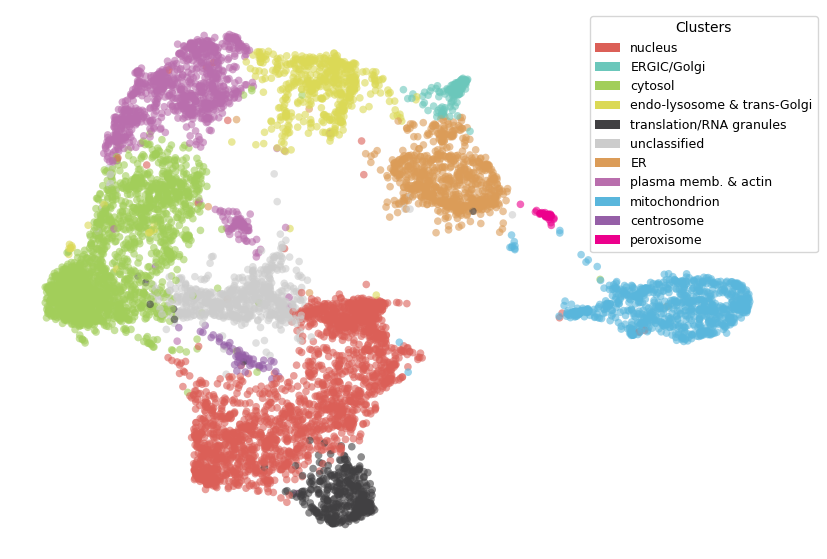

In [20]:
# plot uninfected side of the aligned UMAP
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(
    u_df["JointUMAP_uninf_1"], u_df["JointUMAP_uninf_2"],
    c=[colorDict[cat] for cat in u_df[f"cluster_annot_uninf"]],
    s=120, alpha=0.6, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)

# create legend elements from colorDict
legend_elements = [
    mpatches.Patch(facecolor=colorDict[cat], label=cat) 
    for cat in u_df[f"cluster_annot_uninf"].unique()
]
# add legend to the plot
ax.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper right',
          prop={'size': 9})

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# remove splines
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig(os.path.join("output", "uninf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

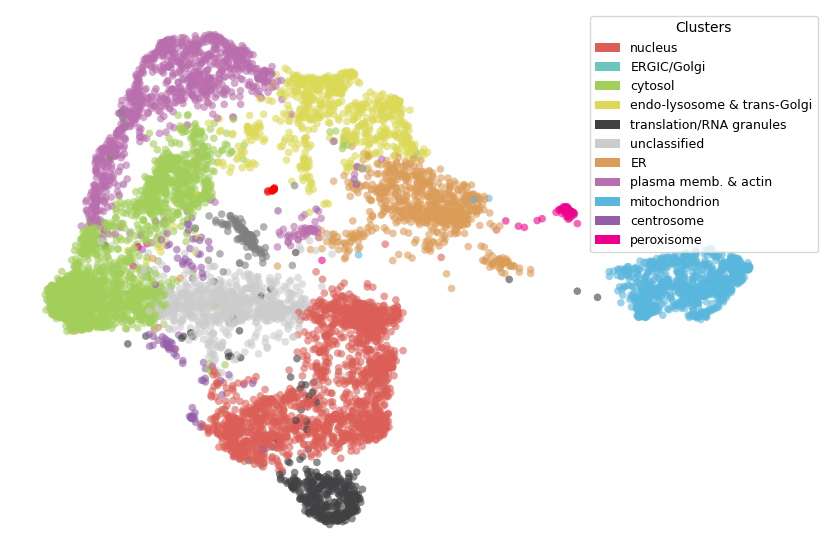

In [21]:
# plot infected side of the aligned UMAP
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(
    u_df["JointUMAP_inf_1"], u_df["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in u_df[f"cluster_annot_inf"]],
    s=120, alpha=0.6, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)

# create legend elements from colorDict
legend_elements = [
    mpatches.Patch(facecolor=colorDict[cat], label=cat) 
    for cat in u_df[f"cluster_annot_uninf"].unique()
]
# add legend to the plot
ax.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper right',
          prop={'size': 9})

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# remove splines
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

In [22]:
# save the results for panels D and E
u_df.to_csv(output_folder / f"{fig5_timestamp}_umap_table.csv")